In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torchvision.models import resnet50
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import os

print(torch.__version__)
print(torchvision.__version__)

# 1. Custom Dataset for a folder of images
class ImageFolderDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.image_files = [f for f in os.listdir(data_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.data_dir, self.image_files[idx])
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, 0  # Return 0 as a dummy label

# 2. Data Loading and Preprocessing
def load_data(data_dir):
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
   
    dataset = ImageFolderDataset(data_dir, transform=transform)
    dataloader = DataLoader(dataset, batch_size=8, shuffle=True, num_workers=2)
   
    return dataloader

# 3. Multi-scale Feature Extraction
class MultiScaleFeatureExtractor(nn.Module):
    def __init__(self):
        super(MultiScaleFeatureExtractor, self).__init__()
        self.resnet = resnet50(pretrained=True)
       
    def forward(self, x):
        features = []
        x = self.resnet.conv1(x)
        x = self.resnet.bn1(x)
        x = self.resnet.relu(x)
        x = self.resnet.maxpool(x)
       
        x = self.resnet.layer1(x)
        features.append(x)  # Fine scale
       
        x = self.resnet.layer2(x)
        features.append(x)  # Medium scale
       
        x = self.resnet.layer3(x)
        features.append(x)  # Coarse scale
       
        return features

2.3.1+cu121
0.18.1+cu121


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import time

class ScaleSpecificTransformerEncoder(nn.Module):
    def __init__(self, d_model, nhead, dim_feedforward=2048, dropout=0.1):
        super().__init__()
        self.self_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout)
        self.linear1 = nn.Linear(d_model, dim_feedforward)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(dim_feedforward, d_model)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, src):
        src2 = self.self_attn(src, src, src)[0]
        src = src + self.dropout1(src2)
        src = self.norm1(src)
        src2 = self.linear2(self.dropout(F.relu(self.linear1(src))))
        src = src + self.dropout2(src2)
        src = self.norm2(src)
        return src

class CrossScaleAttention(nn.Module):
    def __init__(self, d_model, nhead, dropout=0.1):
        super().__init__()
        self.multihead_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout)

    def forward(self, query, key, value):
        return self.multihead_attn(query, key, value)[0]

class HierarchicalPooling(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.pool = nn.AdaptiveAvgPool2d((1, 1))  # Reduce spatial dims to 1x1
        self.fc = nn.Linear(in_features, out_features)

    def forward(self, x):
        # x shape: [B, C, H, W]
        x = self.pool(x)  # Shape: [B, C, 1, 1]
        x = x.view(x.size(0), -1)  # Shape: [B, C]
        x = self.fc(x)  # Shape: [B, out_features]
        return x.view(x.size(0), x.size(1), 1, 1)  # Shape: [B, out_features, 1, 1]

class HierarchicalTransformer(nn.Module):
    def __init__(self, num_scales, d_model, nhead, num_classes):
        super().__init__()
        self.num_scales = num_scales
        self.d_model = d_model

        self.transformers = nn.ModuleList([
            ScaleSpecificTransformerEncoder(d_model, nhead)
            for _ in range(num_scales)
        ])

        self.cross_attentions = nn.ModuleList([
            CrossScaleAttention(d_model, nhead)
            for _ in range(num_scales - 1)
        ])

        self.hierarchical_pooling = nn.ModuleList([
            HierarchicalPooling(d_model, d_model)
            for _ in range(num_scales - 1)
        ])

        self.classifier = nn.Linear(d_model, num_classes)

    def forward(self, features):
        print(f"HierarchicalTransformer: Input features shapes: {[f.shape for f in features]}")
        start_time = time.time()

        # Apply scale-specific transformers
        transformed_features = []
        spatial_shapes = []
        for i, (transformer, feature) in enumerate(zip(self.transformers, features)):
            print(f"Applying transformer for scale {i+1}")
            t_start = time.time()
            B, C, H, W = feature.shape
            spatial_shapes.append((H, W))
            flattened = feature.flatten(2).permute(2, 0, 1)
            print(f"  Flattened shape: {flattened.shape}")
            transformed = transformer(flattened)
            print(f"  Transformed shape: {transformed.shape}")
            transformed_features.append(transformed)
            print(f"  Time for scale {i+1}: {time.time() - t_start:.2f} seconds")

        print(f"Scale-specific transformers complete. Time: {time.time() - start_time:.2f} seconds")

        # Apply cross-scale attention and hierarchical pooling
        for i in range(self.num_scales - 1, 0, -1):
            print(f"Processing scale {i}")
            t_start = time.time()
            cross_attn = self.cross_attentions[i-1](
                transformed_features[i-1],
                transformed_features[i],
                transformed_features[i]
            )
            print(f"  Cross-attention shape: {cross_attn.shape}")
            
            # Reshape cross_attn to 4D using the correct spatial dimensions
            L, B, C = cross_attn.shape
            H, W = spatial_shapes[i-1]
            cross_attn_4d = cross_attn.permute(1, 2, 0).reshape(B, C, H, W)
            print(f"  Cross-attention 4D shape: {cross_attn_4d.shape}")
            
            pooled = self.hierarchical_pooling[i-1](cross_attn_4d)
            print(f"  Pooled shape: {pooled.shape}")
            
            # Reshape pooled to match transformed_features shape
            pooled_reshaped = pooled.squeeze(-1).squeeze(-1).unsqueeze(0).expand(L, -1, -1)
            print(f"  Pooled reshaped: {pooled_reshaped.shape}")
            
            print(f"  Transformed feature shape before addition: {transformed_features[i-1].shape}")
            
            # Ensure shapes match before addition
            if transformed_features[i-1].shape != pooled_reshaped.shape:
                raise ValueError(f"Shape mismatch: {transformed_features[i-1].shape} vs {pooled_reshaped.shape}")
            
            transformed_features[i-1] = transformed_features[i-1] + pooled_reshaped
            print(f"  Updated feature shape: {transformed_features[i-1].shape}")
            print(f"  Time for scale {i}: {time.time() - t_start:.2f} seconds")

        print(f"Cross-scale attention and pooling complete. Time: {time.time() - start_time:.2f} seconds")

        # Final classification
        t_start = time.time()
        output = self.classifier(transformed_features[0].mean(dim=0))
        print(f"Classification complete. Time: {time.time() - t_start:.2f} seconds")
        print(f"Output shape: {output.shape}")

        print(f"Total HierarchicalTransformer forward pass time: {time.time() - start_time:.2f} seconds")
        return output

Starting main execution...
Using device: cuda
Loading data...
Data loaded. Time elapsed: 0.25 seconds
Initializing feature extractor...


/home/tim/miniconda3/envs/rapids-24.06/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/tim/miniconda3/envs/rapids-24.06/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Feature extractor initialized. Time elapsed: 0.96 seconds
Initializing Hierarchical Transformer...
Hierarchical Transformer initialized. Time elapsed: 0.98 seconds
Processing a single batch...
Images moved to device. Time elapsed: 0.00 seconds
Extracting multi-scale features...
Features extracted. Time elapsed: 0.42 seconds
Projecting features...
Features projected. Time elapsed: 0.45 seconds
Processing with Hierarchical Transformer...
HierarchicalTransformer: Input features shapes: [torch.Size([8, 128, 56, 56]), torch.Size([8, 128, 28, 28]), torch.Size([8, 128, 14, 14])]
Applying transformer for scale 1
  Flattened shape: torch.Size([3136, 8, 128])
  Transformed shape: torch.Size([3136, 8, 128])
  Time for scale 1: 0.15 seconds
Applying transformer for scale 2
  Flattened shape: torch.Size([784, 8, 128])
  Transformed shape: torch.Size([784, 8, 128])
  Time for scale 2: 0.00 seconds
Applying transformer for scale 3
  Flattened shape: torch.Size([196, 8, 128])
  Transformed shape: torc

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9124069..1.9733893].


Generating visualizations...
Visualization saved as 'feature_visualization.png'
Output shape from Hierarchical Transformer: torch.Size([8, 10])
Total execution time: 2.20 seconds
Data preparation, feature extraction, and Hierarchical Transformer processing complete.


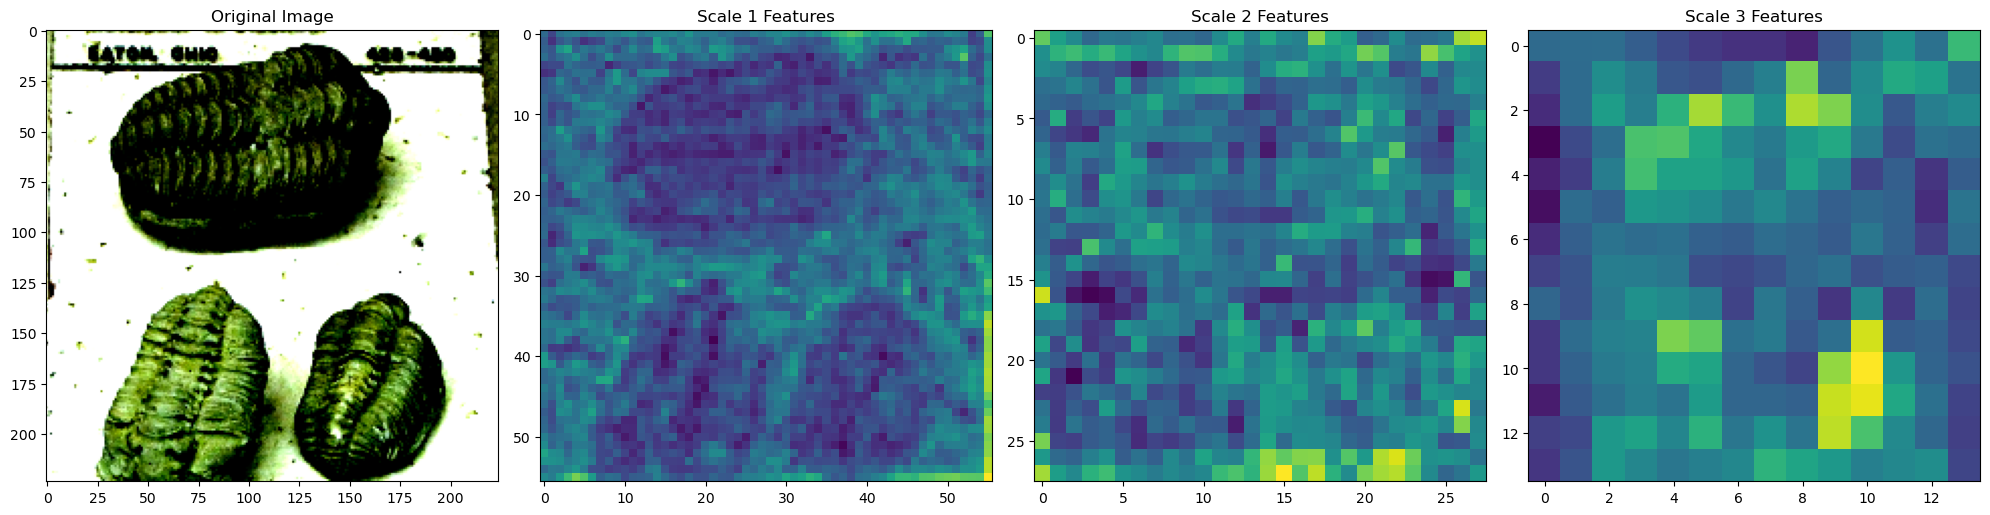

In [3]:
import time

# Main execution
if __name__ == "__main__":
    start_time = time.time()
    
    print("Starting main execution...")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
   
    # Load data
    print("Loading data...")
    dataloader = load_data('../test_images')
    print(f"Data loaded. Time elapsed: {time.time() - start_time:.2f} seconds")
   
    # Initialize feature extractor
    print("Initializing feature extractor...")
    feature_extractor = MultiScaleFeatureExtractor().to(device)
    print(f"Feature extractor initialized. Time elapsed: {time.time() - start_time:.2f} seconds")
   
    # Initialize Hierarchical Transformer
    print("Initializing Hierarchical Transformer...")
    num_scales = 3
    d_model = 128  
    nhead = 4
    num_classes = 10
    hierarchical_transformer = HierarchicalTransformer(num_scales, d_model, nhead, num_classes).to(device)
    print(f"Hierarchical Transformer initialized. Time elapsed: {time.time() - start_time:.2f} seconds")
   
    # Extract features and process with Hierarchical Transformer
    print("Processing a single batch...")
    for images, _ in dataloader:
        batch_start_time = time.time()
        images = images.to(device)
        print(f"Images moved to device. Time elapsed: {time.time() - batch_start_time:.2f} seconds")
        
        print("Extracting multi-scale features...")
        multi_scale_features = feature_extractor(images)
        print(f"Features extracted. Time elapsed: {time.time() - batch_start_time:.2f} seconds")
        
        print("Projecting features...")
        projected_features = [nn.Linear(f.size(1), d_model).to(device)(f.flatten(2).transpose(1, 2)).transpose(1, 2).reshape(f.size(0), d_model, *f.size()[2:]) for f in multi_scale_features]
        print(f"Features projected. Time elapsed: {time.time() - batch_start_time:.2f} seconds")
        
        print("Processing with Hierarchical Transformer...")
        output = hierarchical_transformer(projected_features)
        print(f"Hierarchical Transformer processing complete. Time elapsed: {time.time() - batch_start_time:.2f} seconds")
        break  # Process only one batch
   
    # Visualize a sample image and its feature maps
    print("Generating visualizations...")
    plt.figure(figsize=(20, 5))
    plt.subplot(1, 4, 1)
    plt.imshow(images[0].cpu().permute(1, 2, 0))
    plt.title("Original Image")
   
    for i, features in enumerate(multi_scale_features):
        plt.subplot(1, 4, i+2)
        plt.imshow(features[0].sum(dim=0).cpu().detach().numpy())
        plt.title(f"Scale {i+1} Features")
   
    plt.tight_layout()
    plt.savefig('feature_visualization.png')  # Save the plot instead of showing it
    print("Visualization saved as 'feature_visualization.png'")

    print(f"Output shape from Hierarchical Transformer: {output.shape}")
    print(f"Total execution time: {time.time() - start_time:.2f} seconds")
    print("Data preparation, feature extraction, and Hierarchical Transformer processing complete.")

In [ ]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import os

# Define the data transformations
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Set the path to your dataset
data_dir = '../test_images'  # Replace with your actual data directory

# Load the full dataset
full_dataset = datasets.ImageFolder(root=data_dir, transform=transform)

# Split the dataset into training and validation sets
train_size = int(0.8 * len(full_dataset))  # 80% for training
val_size = len(full_dataset) - train_size  # 20% for validation
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# Create the data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

# Print some information about the datasets
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of validation samples: {len(val_dataset)}")
print(f"Number of classes: {len(full_dataset.classes)}")
print(f"Class names: {full_dataset.classes}")

# You can now use train_loader and val_loader in your training loop

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim

# Assuming you have your data loaded into train_loader and val_loader
model = HierarchicalTransformer(num_scales=3, d_model=128, nhead=4, num_classes=10)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        if batch_idx % 100 == 0:
            print(f'Epoch {epoch}, Batch {batch_idx}, Loss: {loss.item()}')
    
    model.eval()
    val_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in val_loader:
            output = model(data)
            val_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    
    val_loss /= len(val_loader)
    accuracy = correct / len(val_loader.dataset)
    print(f'Epoch {epoch}, Validation Loss: {val_loss}, Accuracy: {accuracy}')

NameError: name 'train_loader' is not defined